In [3]:
# suppress warnings
import warnings
warnings.simplefilter('ignore')
# import installed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0,'/Users/Kathy/Desktop/UW/seaflow/decomposition_project/scripts/')
from rate_functions import *
from simulation_tools import *

## Generate data

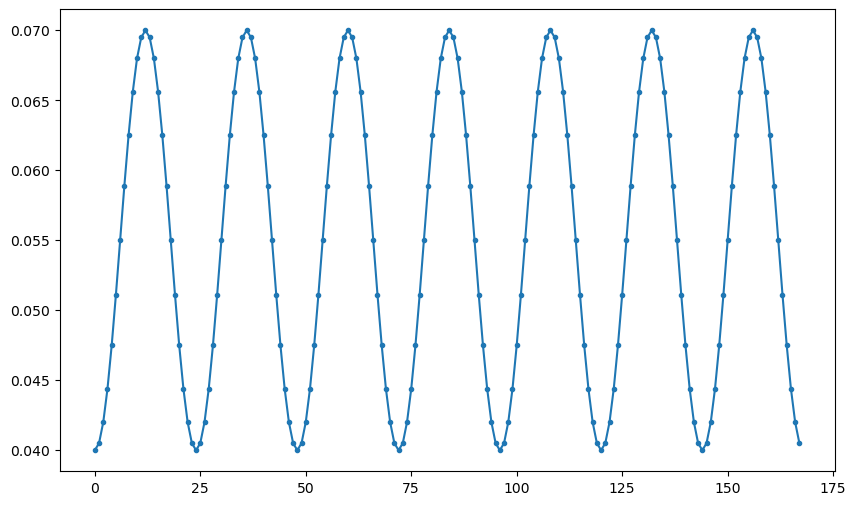

In [4]:
# generate simulation data with known periodicity of 24H, 10 full days
cycles = 8 # how many sine cycles
resolution = cycles*24 # how many datapoints to generate
# calculate length
length = np.pi * 2 * cycles
# set x with custom amplitude
x=np.arange(0, length, length / resolution)
# adjust amplitude and start/end
my_wave = 0.15*np.sin(x) + 0.55
start=np.where(my_wave == np.min(my_wave))[0][0]
end=np.where(my_wave == np.min(my_wave))[0][-1]-1
# crop wave
new_wave=my_wave[start:end+1]/10

# show simulation data
fig,axs=plt.subplots(figsize=(10,6))
axs.plot(new_wave, marker='.')

In [5]:
## scenario 2
## add trend
day_len=24
days=np.arange(0, len(new_wave), day_len)
trend=np.linspace(0.9, 1.2, 7)
data2=new_wave.copy()
# loop through eacy day
for day, m in zip(days, trend):
    data2[day:day+day_len]=data2[day:day+day_len]*m
# show simulation data
# fig,axs=plt.subplots(figsize=(10,6))
# axs.plot(data2, marker='.')

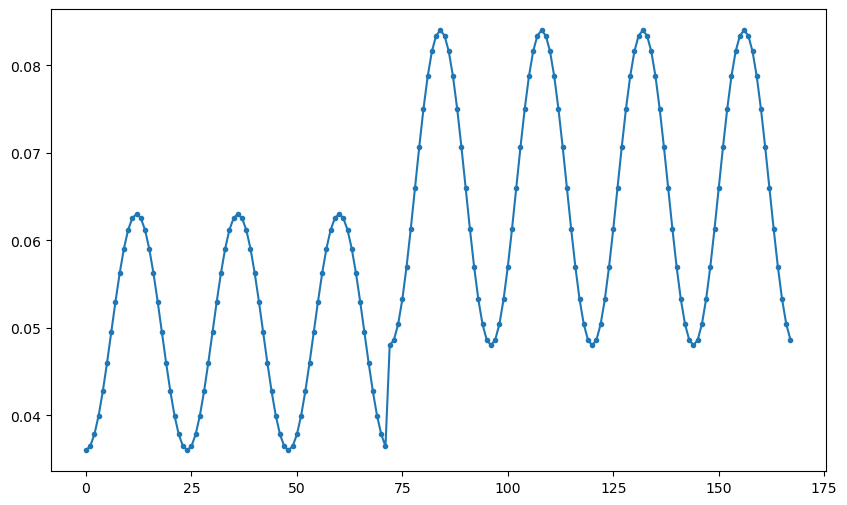

In [6]:
## scenario 3
data3=new_wave.copy()
# separate first 3 days
chunk1=new_wave[:day_len*3]*0.9
chunk2=new_wave[day_len*3:]*1.2
# concatenate
breaks=np.concatenate([chunk1,chunk2])

# # show simulation data
fig,axs=plt.subplots(figsize=(10,6))
axs.plot(breaks, marker='.')

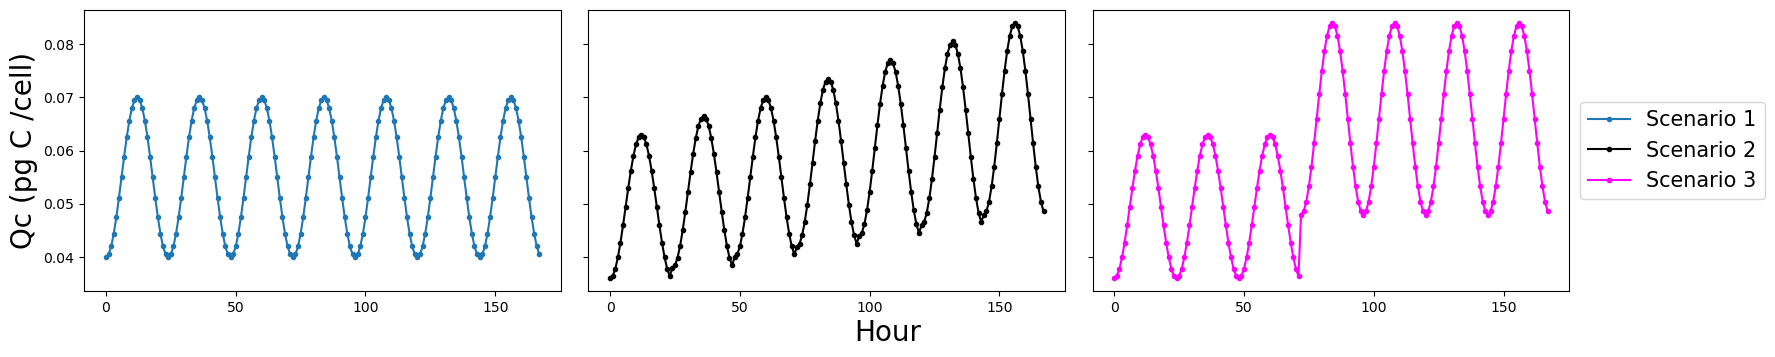

In [6]:
# show simulation data
fig,axs=plt.subplots(figsize=(18,3.5), ncols=3, sharey=True)
ln1=axs[0].plot(new_wave, marker='.', label='Scenario 1')
axs[0].set_ylabel('Qc (pg C /cell)', size=20)
ln2=axs[1].plot(data2, marker='.', c='k', label='Scenario 2')
ln3=axs[2].plot(breaks, marker='.', c='magenta', label='Scenario 3')
fig.text(0.5, -0.01, 'Hour', ha='center', size=20)
plt.rcParams.update({'font.size':15})
lns=ln1+ln2+ln3
labs = [l.get_label() for l in lns]
axs[2].legend(lns,labs,loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

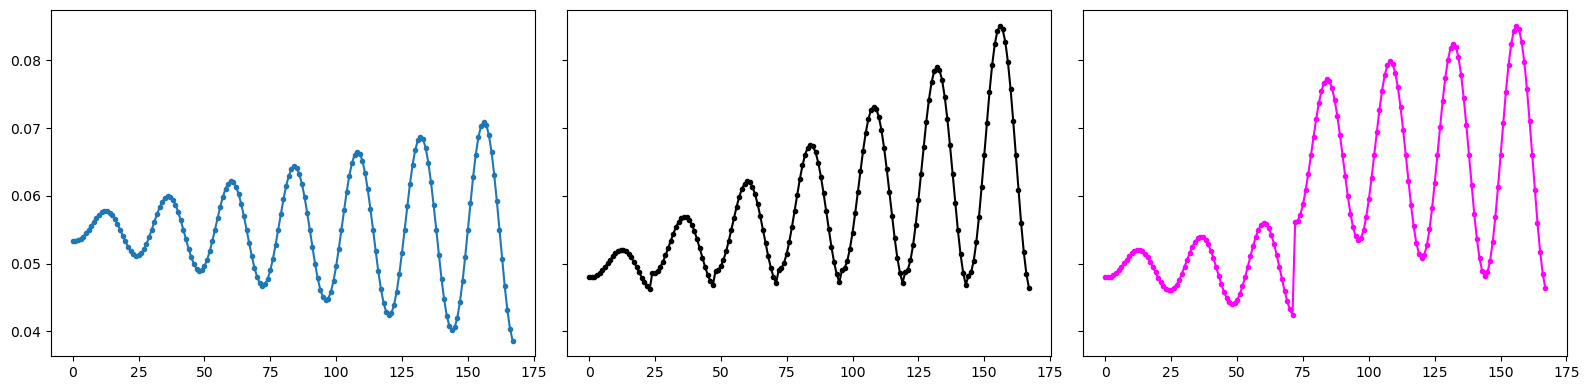

In [7]:
## now generate for changing amplitudes
## scenario 1
# generate simulation data with known periodicity of 24H, 10 full days
cycles = 8 # how many sine cycles
resolution = cycles*24 # how many datapoints to generate
# calculate length
length = np.pi * 2 * cycles
# set x with custom amplitude
x=np.arange(0, length, length / resolution)
# adjust amplitude and start/end
my_wave = np.sin(x)#*0.15 + 0.55
am_wave=my_wave*x*0.0035+0.55
start=np.where(my_wave == np.min(my_wave))[0][0]
end=np.where(my_wave == np.min(my_wave))[0][-1]-1
# crop wave
moving_wave=am_wave[start:end+1]/10


## scenario 2
day_len=24
moving_data2=moving_wave.copy()
# loop through eacy day
for day, m in zip(days, trend):
    moving_data2[day:day+day_len]=moving_data2[day:day+day_len]*m

plt.show()

## scenario 3
moving_data3=moving_wave.copy()
# separate first 3 days
chunk1=moving_wave[:day_len*3]*0.9
chunk2=moving_wave[day_len*3:]*1.2
# concatenate
moving_breaks=np.concatenate([chunk1,chunk2])

# # show simulation data
fig,axs=plt.subplots(figsize=(16,4),ncols=3,sharey=True)
axs[0].plot(moving_wave,marker='.')
axs[1].plot(moving_data2,marker='.',c='k')
axs[2].plot(moving_breaks, marker='.',c='magenta')
plt.tight_layout()
plt.show()

## calculate µ
- Annette's method: ln(QC)=r×t+ln(QC,0),

In [9]:
## deprecated helper function
def sr_hourly_growth(df, col, start):
    # get qc vals
    curr_qc=df[col]
    sr_qc=df.loc[df['time_of_day']=='sunrise', col].values
    # get time after sunrise
    sr_time=curr_qc.index.values-start
    growth=(np.log(curr_qc)-np.log(sr_qc))/sr_time
    return growth

## helper function to calculate p-value for linear regression
def calc_pvalue(X,y,params,pred):
    new_X = np.append(np.ones((len(X),1)), X, axis=1)
    # calculate mean squared error
    MSE = (sum((y-pred)**2))/(len(new_X)-len(new_X[0]))
    # matrix algebra to get p-value
    v_b = MSE*(np.linalg.inv(np.dot(new_X.T,new_X)).diagonal())
    s_b = np.sqrt(v_b)
    t_b = params/ s_b
    p_val =[2*(1-stats.t.cdf(np.abs(i),(len(new_X)-len(new_X[0])))) for i in t_b]
    # return raw p-value
    return(p_val[1])

## helper function to calculate daily averaged hourly growth rate
from sklearn.linear_model import LinearRegression
from scipy import stats
def calc_daily_avg_growth(df, col, model='not base'):
    # check model type
    if model=='base':
        base_df=pd.concat([df.head(1), df.tail(1)])
        # fit data on only first and last values
        X = np.array([0, int(base_df['hour'].diff().values[1])]).reshape(-1, 1)
        y = np.log(base_df[col].values)
        # set y intercept as first value
        y_int=np.log(base_df.head(1)[col].values[0])
    else:
        # fit data on entire day
        X = np.arange(0, len(df)).reshape(-1, 1)
        y = np.log(df[col].values)
        # add y intercent, log Qc at sunrise
        y_int=np.log(df.loc[df['time_of_day']=='sunrise', col]).values[0]
        
    # Step 1: Subtract the known y-intercept from all y values
    y_centered = y - y_int
    # Step 2: Fit the linear regression model
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y_centered)
    # Step 3: Add the known y-intercept back to the model's intercept
    model.intercept_ += y_int
    # get slope and coefficients
    slope=model.coef_[0]
    params = np.append(model.intercept_,model.coef_)
    # step 4: predict new y values on original df's X and dY
    X = np.arange(0, len(df)).reshape(-1, 1)
    y = np.log(df[col].values)
    pred=model.predict(X)

    # calculate p-value and standard error
    pval=calc_pvalue(X,y,params,pred)
    se=calc_se(X,y,params,pred)
    return(slope, pval,se)

## helper function to find daily growth for each day in a cruise
# save calculated daily growth rates
def calc_diel_growth(df,col,model,day_len=12):
    # calculate number of days of time series
    days=df.loc[df['time_of_day']=='sunrise'].index.values-1
    # store growth and calculated p values
    daily_growth=[]
    pvals=[]
    ses=[]
    # sunrise 1 hour after minimum, sunset 1 hour after maximum
    for day in days:
        start=day+1
        # set sunrise, sunset, and day time 
        df.loc[start,'time_of_day']='sunrise'
        df[start+1:start+day_len]['time_of_day']='day'
        df.loc[start+day_len,'time_of_day']='sunset'
        # calcaulate daily averaged hourly growth since sunrise
        if model.startswith('base'):
            ## check if any rows are null
            base_day=df[start:start+day_len]
            if len(base_day.loc[base_day[col].isnull()]) >0:
                # find first and last null values
                base_good=base_day.loc[base_day[col].notnull()]
                # skip if whole day is empty or only has 1 hour
                if len(base_good)<2:
                    # save values as nan
                    daily_growth.append(np.nan)
                    pvals.append(np.nan)
                    ses.append(np.nan)
                    continue
                # else calculate growth on non-null values
                slope, pval, se=calc_daily_avg_growth(base_good, col,model='base')
                slope=slope/(len(base_good))
            else:
                # need to divide by the number of hours that have passed
                slope, pval, se=calc_daily_avg_growth(base_day, col, model='base')
                slope=slope/(day_len-1)
        else:
            slope, pval, se=calc_daily_avg_growth(df[start:start+day_len], col)
        daily_growth.append(slope)
        pvals.append(pval)
        ses.append(se)
    # return as dataframe
    growth_df=pd.DataFrame(data=[daily_growth,pvals,ses]).T
    growth_df.columns=['growth','pval','se']
    growth_df['model']=model
    return(growth_df)

## running entire model w/o bootstrapping or zinser data
def run_full_model(df, col, remove=0, noise=0, blocks=False, model='STL', show_plots=True):
    # first generate noise if prompted
    if noise > 0:
        # calculate std to sample from noise
        x=df[col]
        # set mean to 0 for gaussian noise
        mu=0
        std = noise * np.std(x) 
        # add noise to data
        df['data_with_noise']=gaussian_noise(x,mu,std)
    # don't generate noise    
    else:
        df['data_with_noise']=df[col]
    
    # generate missing data if prompted
    if remove > 0:
        # generate blocks of missing datam
        if blocks:
            # remove block length and amount of data to remove
            missing=generate_random_chunks(df,'data_with_noise',remove, missing_col='data_with_missing')
        else:
            # generate misisng data at random
            missing=generate_missing_data(df, 'data_with_noise', remove,missing_col='data_with_missing')
        # save missing data
        missing_data=missing['data_with_missing']
        # calculate imputed values
        impute_df=run_imputation(missing, 'data_with_noise', missing_col='data_with_missing',period=24, interval=1)
        # rename col
        impute_df.rename(columns={'with_missing':'data_with_missing'},inplace=True)
        # reset time of day columns
        impute_df['time_of_day']=df['time_of_day']
        # check if imputation ran
        if impute_df is None:
            print('Imputation Failed')
            return
    else: # run STL model on complete dataset (no missing values)
        # add necessary columns
        impute_df=df.copy()
        # replace with noise column (doesn't matter if noise was added or not)
        impute_df['with_missing']=impute_df['data_with_noise']
        # check if there are missing values, and replace with noise
        impute_df['data_with_missing']=np.where(impute_df['with_missing']>0, impute_df['with_missing'], 
         np.mean(impute_df['with_missing']))
        # save missing data
        missing_data=impute_df['data_with_missing']

    ## run STL model
    if model.lower().startswith('s'):
        # get tsd components
        tsd_df=run_STL(impute_df, col='data_with_missing',period=24)
        # calculate growth
        growth_df=calc_diel_growth(tsd_df, 'diel', model)
        growth_df['remove']=remove
        growth_df['noise']=noise
    ## run naive model
    elif model.lower().startswith('n'):
        # get tsd components
        tsd_df=run_naive(impute_df, col='data_with_missing',period=24)
        # save missing components 
        tsd_df['unfilled']=missing_data
        growth_df=calc_diel_growth(tsd_df, 'diel', model)
        growth_df['remove']=remove
        growth_df['noise']=noise
    ## run STL model
    elif model.lower().startswith('roll'):
        # get components from rolling model
        pro_seasonal, pro_trend, pro_resid = rolling_tsd(impute_df.set_index('hour'), 'data_with_missing', period=24,
                                                        window=3, type='log additive', extrapolate=True)
        pro_all=summarize_rolling(pro_seasonal, pro_trend, pro_resid)
        pro_all.rename(columns={'seasonal':'diel'}, inplace=True)
        # get other necessary columns`a
        tsd_df=pd.merge(pro_all, impute_df[['hour','time_of_day','data_with_missing']], on='hour')
        # calculate growth and productivity
        growth_df=calc_diel_growth(tsd_df, 'diel', model)
        growth_df['remove']=remove
        growth_df['noise']=noise
    ## run baseline model (just dusk+dawn, no decomposition)
    elif model.lower().startswith('base'):
        tsd_df=impute_df.copy()
        # replace with missing data (don't use imputed values) if remove >0; else leave as is
        if remove > 0:
            tsd_df['data_with_missing']=missing['data_with_missing']
        growth_df=calc_diel_growth(tsd_df, 'data_with_missing',model)
        growth_df['remove']=remove
        growth_df['noise']=noise
        
    else: 
        return('Choose a valid model: baseline, naive, rolling, or STL')
    return(tsd_df, growth_df)

## Estimate levels of noise to test

In [10]:
### run simulation calculating the mean SE per noise level
## testing with noise levels
test_noise=trial1_df.copy()
x=test_noise['data1']
noise_levels=np.linspace(0,1,21)
n=100
# set mean to 0 for gaussian noise
mu=0
# results
noise_dfs=[]
for noise in noise_levels:
    print(noise)
    # run n times
    for i in range(0,n):
        # calculate std to sample from noise
        std = noise * np.std(x) 
        # add noise to data
        test_noise['data_with_noise']=gaussian_noise(x,mu,std)
        # calcaulte growth rate and SE
        test_growth=calc_diel_growth(test_noise, 'data_with_noise','naive')
        test_growth['noise']=noise
        # save df
        noise_dfs.append(test_growth)
noise_results=pd.concat(noise_dfs)

NameError: name 'trial1_df' is not defined

0.5
0.0097689438560931


<AxesSubplot:xlabel='se', ylabel='Count'>

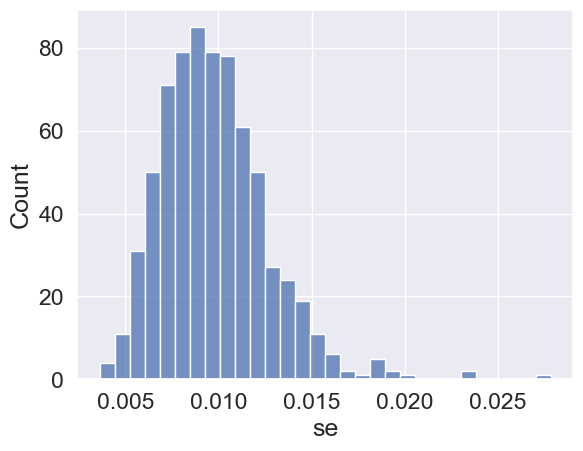

In [884]:
noisy=noise_levels[10]
print(noisy)
noise_02=noise_results.loc[noise_results['noise']==noisy]
print(np.mean(noise_02['se']))
sns.histplot(noise_02, x='se')

Text(0, 0.5, 'Standard Error')

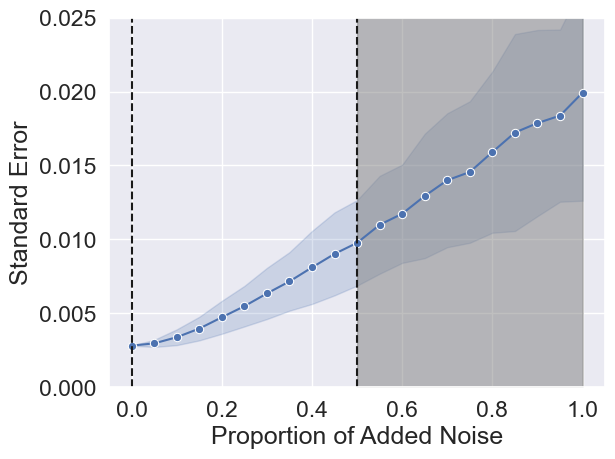

In [895]:
fig,axs=plt.subplots()
sns.lineplot(noise_results, x='noise',y='se',err_style='band',errorbar='sd',marker='o',ax=axs)
# add lines to show range
axs.axvline(x=0, c='k',linestyle='--')
axs.axvline(x=0.5, c='k',linestyle='--')
# shade unused region
axs.fill_between(noise_results['noise'], 0,1, 
                    where=noise_results['noise']>=0.5,color='gray', alpha=0.5, transform=axs.get_xaxis_transform())
# set lims
axs.set_ylim(0,0.025)

# labels
axs.set_xlabel('Proportion of Added Noise')
axs.set_ylabel('Standard Error')

In [885]:
sub_noise=noise_results.loc[noise_results['noise']>=0.4]
np.min(sub_noise['se'])

0.002737856213789586

## Calculate growth rates from simulated datasets

### truth data testing

In [83]:
### calculate truth data
# store data in df 
sim_df=pd.DataFrame([new_wave, data2, breaks,moving_wave,moving_data2,moving_breaks]).T
sim_df.columns=['data1','data2','data3','moving_data1','moving_data2','moving_data3']
## let's assume when day and night are based on zinser dataset
sim_df['time_of_day']='night'
# save calculated daily growth rates
actual_growth=[]
pvals=[]
# sunrise 1 hour after minimum, sunset 1 hour after maximum
day_len=12
for day in days:
    start=day+1
    # set sunrise and sunset
    sim_df.loc[start,'time_of_day']='sunrise'
    sim_df.loc[start+day_len,'time_of_day']='sunset'
    sim_df[start+1:start+day_len]['time_of_day']='day'
    # calcaulate daily averaged hourly growth since sunrise
    slope, pval, se=calc_daily_avg_growth(sim_df[start:start+day_len], 'data3')
    actual_growth.append(slope)
    pvals.append(pval)
    # calcualte hourly growth
    sim_df.loc[np.arange(start,start+day_len),'hourly_growth']=exp_growth(sim_df[start:start+day_len],
                                                                          'data3',1)
    sim_df.loc[sim_df['hourly_growth'].isnull(), 'hourly_growth']=0

# fig,axs=plt.subplots(figsize=(10,6))
# axs.plot(sim_df['data1'],marker='.')
# # axs.plot(sim_df['sr_growth'], marker='.')
# axs.plot(sim_df['hourly_growth'], marker='.')

In [84]:
actual_growth

[0.05605465003967587,
 0.05605465003967586,
 0.05605465003967584,
 0.056054650039675816,
 0.05605465003967587,
 0.056054650039675795,
 0.056054650039675795]

### simulated data testing

In [86]:
# run trials for each step
trial1_df=sim_df[['data1','data2','data3','moving_data1','moving_data2','moving_data3','time_of_day']]
trial1_df['hour']=trial1_df.index

# scenarios=['moving_data1','moving_data2','moving_data3']
scenarios=['data1','data2','data3']
s_names=[1,2,3]
# models=['naive','rolling','stl','base']
models=['base']
# start data removed experiments
# data_levels=np.linspace(0,1,11)
data_levels=[0, 0.5]
# save dataframes
result_dfs=[]
# save growth rates
result_growths=[]

# let's also run this many times!
for i in range(0,1):
    print(i)
    for s,name in zip(scenarios, s_names):
        for model in models:
                # run model with data removed
                for data in data_levels:
                    print(data)
                    # try running full model, skip if error
                    try:
                        tsd_df, growth_df=run_full_model(trial1_df, s,model=model, noise=data)
                    except Exception as error:
                        print(f'failed: {error}')
                        continue
                    # save data and model
                    tsd_df['model']=model
                    # show amount of data removed
                    tsd_df['noise']=data
                    # calculate actual growth,set fixed to naive bc model dpesn't matter in growth calculation
                    actual_growth_df=calc_diel_growth(trial1_df,s,'naive')
                    # only get non-null values to calculate RMSE
                    good_growth=growth_df.loc[growth_df['growth'].notnull()]
                    good_actual=actual_growth_df.loc[good_growth.index]
                    ############ debugging ############
                    display(good_actual)
                    display(good_growth)
                    ###################################
                    rmse=mean_squared_error(good_actual['growth'].values, 
                                            good_growth['growth'].values, squared=False)
                    # save values
                    tsd_df['rmse']=rmse
                    tsd_df['scenario']=name
                    growth_df['scenario']=name
                    # save results
                    result_dfs.append(tsd_df)
                    result_growths.append(growth_df)
                    # show progress 
                    print(f'Completed Scenario: {s}, Model: {model}, Noise: {data}, RMSE: {rmse}')

0
0


,growth,pval,se,model
0,0.056055,2.240930e-09,0.002815,naive
1,0.056055,2.240930e-09,0.002815,naive
2,0.056055,2.240930e-09,0.002815,naive
3,0.056055,2.240930e-09,0.002815,naive
4,0.056055,2.240930e-09,0.002815,naive
5,0.056055,2.240930e-09,0.002815,naive
6,0.056055,2.240930e-09,0.002815,naive


,growth,pval,se,model,remove,noise
0,0.00452,9.538258e-07,0.004704,base,0,0
1,0.00452,9.538258e-07,0.004704,base,0,0
2,0.00452,9.538258e-07,0.004704,base,0,0
3,0.00452,9.538258e-07,0.004704,base,0,0
4,0.00452,9.538258e-07,0.004704,base,0,0
5,0.00452,9.538258e-07,0.004704,base,0,0
6,0.00452,9.538258e-07,0.004704,base,0,0


Completed Scenario: data1, Model: base, Noise: 0, RMSE: 0.05153465896324114
0.5


,growth,pval,se,model
0,0.056055,2.240930e-09,0.002815,naive
1,0.056055,2.240930e-09,0.002815,naive
2,0.056055,2.240930e-09,0.002815,naive
3,0.056055,2.240930e-09,0.002815,naive
4,0.056055,2.240930e-09,0.002815,naive
5,0.056055,2.240930e-09,0.002815,naive
6,0.056055,2.240930e-09,0.002815,naive


,growth,pval,se,model,remove,noise
0,0.004524,6.649144e-04,0.010246,base,0,0.5
1,0.003700,7.822910e-03,0.012280,base,0,0.5
2,0.004938,1.705020e-03,0.012799,base,0,0.5
3,0.003735,1.389333e-03,0.009392,base,0,0.5
4,0.005518,6.333254e-07,0.005494,base,0,0.5
5,0.004983,2.291323e-04,0.009796,base,0,0.5
6,0.004131,8.668453e-04,0.009709,base,0,0.5


Completed Scenario: data1, Model: base, Noise: 0.5, RMSE: 0.05155439784045708
0


,growth,pval,se,model
0,0.056055,2.240930e-09,0.002815,naive
1,0.056055,2.240930e-09,0.002815,naive
2,0.056055,2.240930e-09,0.002815,naive
3,0.056055,2.240930e-09,0.002815,naive
4,0.056055,2.240930e-09,0.002815,naive
5,0.056055,2.240930e-09,0.002815,naive
6,0.056055,2.240930e-09,0.002815,naive


,growth,pval,se,model,remove,noise
0,0.00452,9.538258e-07,0.004704,base,0,0
1,0.00452,9.538258e-07,0.004704,base,0,0
2,0.00452,9.538258e-07,0.004704,base,0,0
3,0.00452,9.538258e-07,0.004704,base,0,0
4,0.00452,9.538258e-07,0.004704,base,0,0
5,0.00452,9.538258e-07,0.004704,base,0,0
6,0.00452,9.538258e-07,0.004704,base,0,0


Completed Scenario: data2, Model: base, Noise: 0, RMSE: 0.05153465896324114
0.5


,growth,pval,se,model
0,0.056055,2.240930e-09,0.002815,naive
1,0.056055,2.240930e-09,0.002815,naive
2,0.056055,2.240930e-09,0.002815,naive
3,0.056055,2.240930e-09,0.002815,naive
4,0.056055,2.240930e-09,0.002815,naive
5,0.056055,2.240930e-09,0.002815,naive
6,0.056055,2.240930e-09,0.002815,naive


,growth,pval,se,model,remove,noise
0,0.003820,0.124428,0.025051,base,0,0.5
1,0.002817,0.009484,0.009682,base,0,0.5
2,0.007301,0.002679,0.020271,base,0,0.5
3,0.005257,0.000154,0.009828,base,0,0.5
4,0.003461,0.004035,0.010258,base,0,0.5
5,0.004375,0.000371,0.009157,base,0,0.5
6,0.005641,0.000002,0.006167,base,0,0.5


Completed Scenario: data2, Model: base, Noise: 0.5, RMSE: 0.05140672151142346
0


,growth,pval,se,model
0,0.056055,2.240930e-09,0.002815,naive
1,0.056055,2.240930e-09,0.002815,naive
2,0.056055,2.240930e-09,0.002815,naive
3,0.056055,2.240930e-09,0.002815,naive
4,0.056055,2.240930e-09,0.002815,naive
5,0.056055,2.240930e-09,0.002815,naive
6,0.056055,2.240930e-09,0.002815,naive


,growth,pval,se,model,remove,noise
0,0.00452,9.538258e-07,0.004704,base,0,0
1,0.00452,9.538258e-07,0.004704,base,0,0
2,0.00452,9.538258e-07,0.004704,base,0,0
3,0.00452,9.538258e-07,0.004704,base,0,0
4,0.00452,9.538258e-07,0.004704,base,0,0
5,0.00452,9.538258e-07,0.004704,base,0,0
6,0.00452,9.538258e-07,0.004704,base,0,0


Completed Scenario: data3, Model: base, Noise: 0, RMSE: 0.051534658963241144
0.5


,growth,pval,se,model
0,0.056055,2.240930e-09,0.002815,naive
1,0.056055,2.240930e-09,0.002815,naive
2,0.056055,2.240930e-09,0.002815,naive
3,0.056055,2.240930e-09,0.002815,naive
4,0.056055,2.240930e-09,0.002815,naive
5,0.056055,2.240930e-09,0.002815,naive
6,0.056055,2.240930e-09,0.002815,naive


,growth,pval,se,model,remove,noise
0,0.001687,0.263483,0.015662,base,0,0.5
1,0.003105,0.091847,0.018320,base,0,0.5
2,0.008030,0.003577,0.023341,base,0,0.5
3,0.004108,0.001984,0.010892,base,0,0.5
4,0.006829,0.000744,0.015711,base,0,0.5
5,0.007690,0.000060,0.012798,base,0,0.5
6,0.003591,0.002576,0.009909,base,0,0.5


Completed Scenario: data3, Model: base, Noise: 0.5, RMSE: 0.05110083244989395


In [74]:
actual=np.array([0.00728967, 0.01512659, 0.02308824, 0.03119963, 0.03948792,
       0.04798307, 0.05671853])
pred=np.array([0.0018388 , 0.00168506, 0.00185772, 0.00258057, 0.00191066,
       0.00472703, 0.00463271])
mean_squared_error(actual, pred, squared=False)

0.032680794705133125

In [489]:
def save_data(dfs, experiment, data_type):
    all_dfs=pd.concat(dfs).reset_index()
    all_dfs.to_pickle(f'simulation_data/{experiment}_{data_type}_results')
    return(all_dfs)

In [60]:
moving_base_noise=pd.concat(result_dfs)

In [61]:
np.max(moving_base_noise['rmse'])

0.03493732410559296

In [513]:
# save baseline data
# moving_base_noise=pd.concat(result_dfs)
# noise_moving_rmse.rename(columns={'data':'noise'},inplace=True)
# noise_moving_rmse_new=noise_moving_rmse.loc[noise_moving_rmse['model']!='base']
# # # replace baseline data
# noise_moving_rmse_new=pd.concat([noise_moving_rmse_new, moving_base_noise])
# noise_moving_rmse_new.to_pickle(f'simulation_data/changing_diel_noise_results')

# save simulation data
# remove_results=save_data(result_dfs, 'removed','simulation')
# remove_growths=save_data(result_growths,'removed', 'growth')
# save_data(result_dfs, 'changing_diel','simulation')
# save_data(result_growths, 'changing_diel','growth')
#save_data(result_dfs, 'removed_tsd','changing_diel')
# remove_moving_rmse=save_data(result_dfs, 'removed','changing_diel')
# noise_moving_rmse=save_data(result_dfs, 'noise','changing_diel')
# save_data(result_growths, 'noise_growth','changing_diel')

## read in data
noise_results=pd.read_pickle('simulation_data/noise_simulation_results')
remove_results=pd.read_pickle('simulation_data/removed_simulation_results')
moving_results=pd.read_pickle('simulation_data/changing_diel_simulation_results')

In [812]:
### combine data
## data removed experiments
# constant diel
remove_rmse=remove_results_new[['rmse','scenario','model']]
remove_rmse['trial']='Missing Data'
remove_rmse['diel']='Constant'
# changing diel
remove_moving=remove_moving_rmse_new[['rmse','scenario','model']]
remove_moving['trial']='Missing Data'
remove_moving['diel']='Changing'
## noise experiments
# first subset noise from each experiment
sub_noise=noise_results_new.loc[noise_results_new['noise']<=0.5]
sub_noise_moving=noise_moving_rmse_new.loc[noise_moving_rmse_new['noise']<=0.5]
# constant diel
noise_rmse=sub_noise[['rmse','scenario','model']]
noise_rmse['trial']='Added Noise'
noise_rmse['diel']='Constant'
# changing diel
noise_moving=sub_noise_moving[['rmse','scenario','model']]
noise_moving['trial']='Added Noise'
noise_moving['diel']='Changing'
# concatenate all experiments into 1 df
all_trials=pd.concat([remove_rmse, remove_moving, noise_rmse, noise_moving])

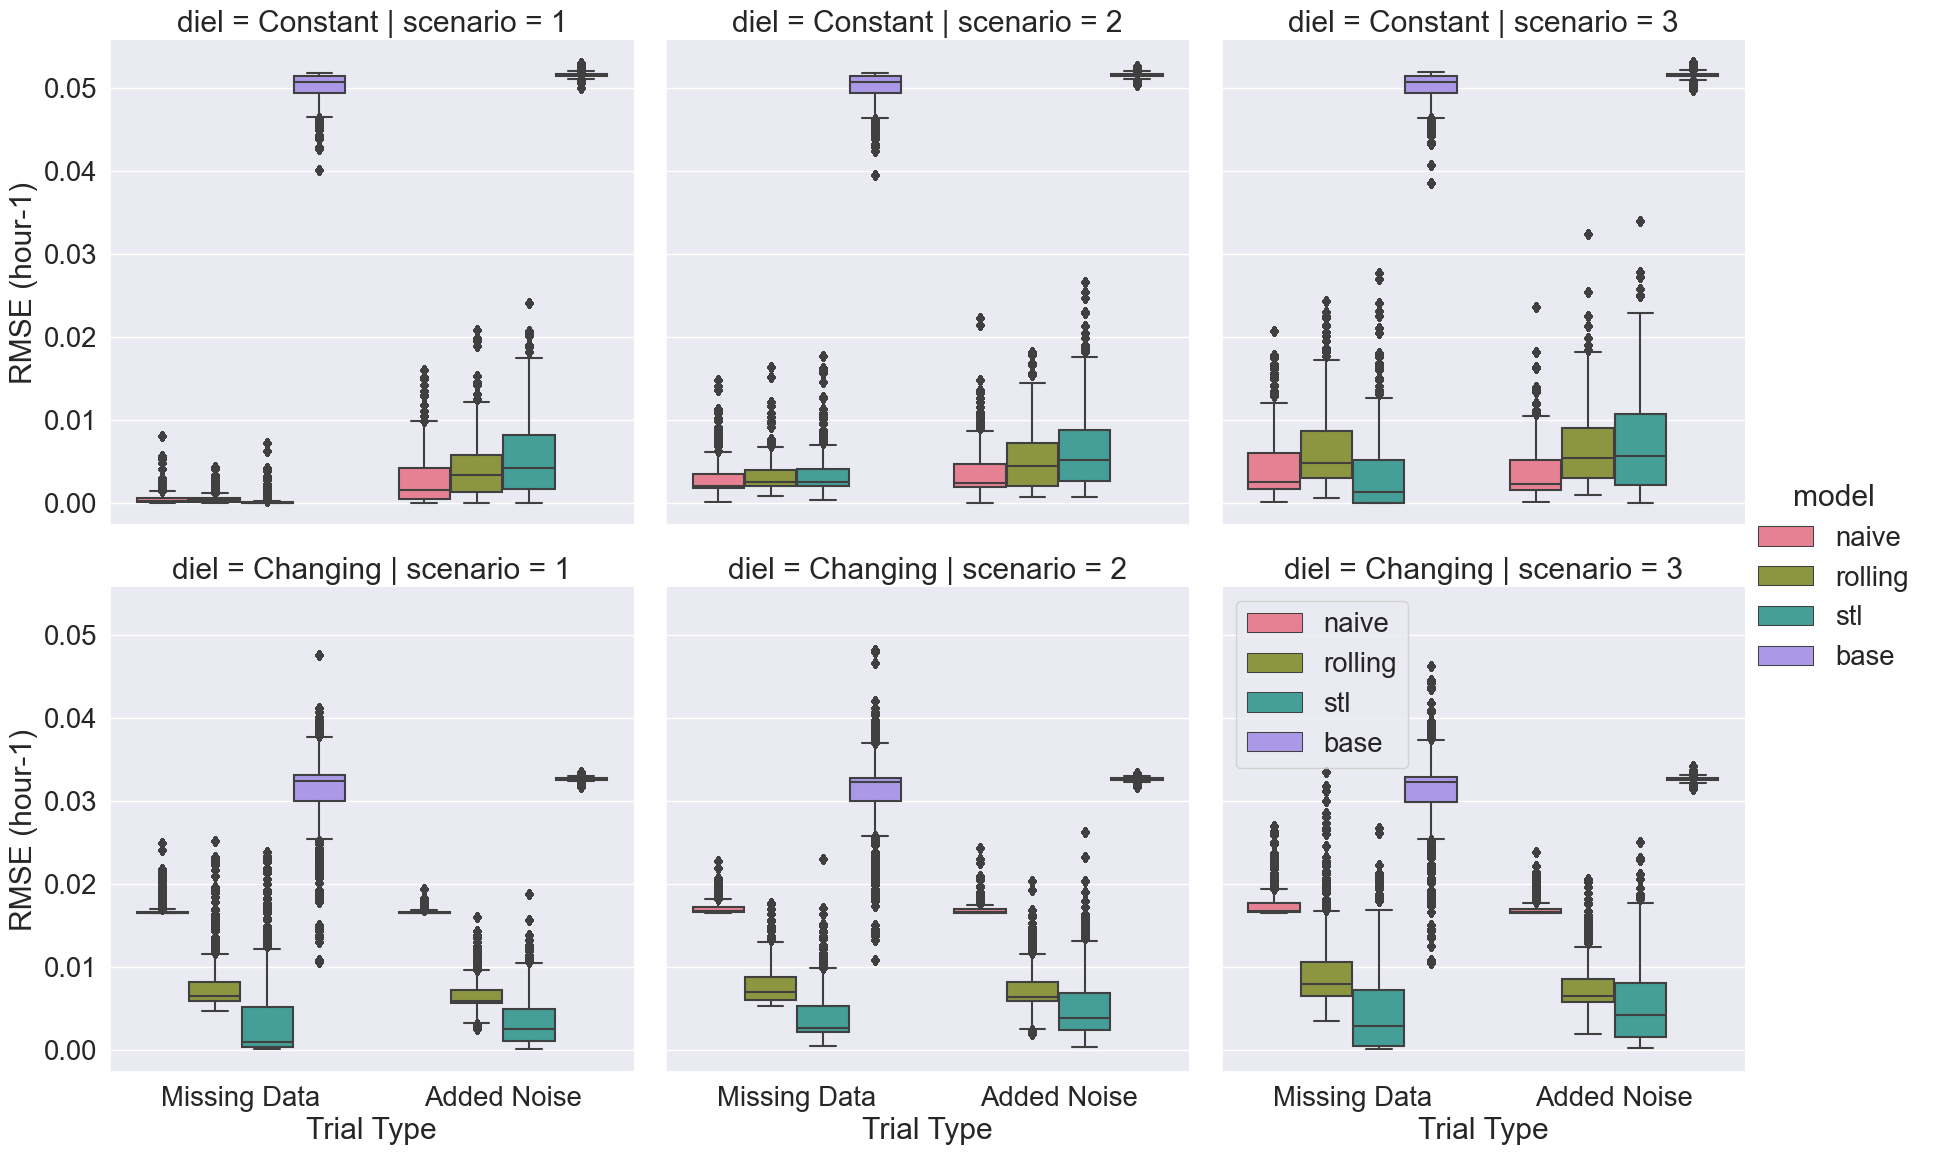

In [850]:
sns.set(font_scale=1.8)
g = sns.catplot(data=all_trials, x='trial', y='rmse', hue='model', col='scenario',
                row='diel', kind='box',palette='husl',
               errorbar='sd',height=6)
plt.legend()
g.set_axis_labels("Trial Type",'RMSE (hour-1)')
# g.set_titles(template="")
plt.show()

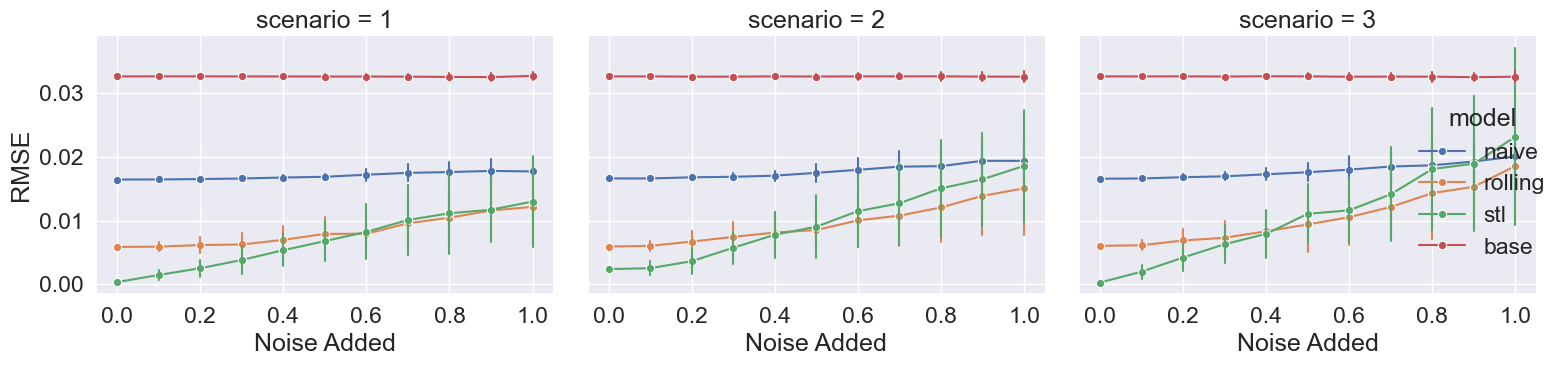

In [856]:
# plot increasing removed with blocks
sns.set(font_scale=1.5)
g = sns.FacetGrid(noise_moving_rmse_new, col="scenario", hue='model',sharey=True, sharex=False,
                 height=4, aspect=1.2)
g.map(sns.lineplot, "noise", "rmse", marker='o',err_style='bars',ci='sd')
g.add_legend()
g.set_axis_labels("Noise Added")
axes = g.axes.flatten()
axes[0].set_ylabel('RMSE')
plt.tight_layout()
plt.show()

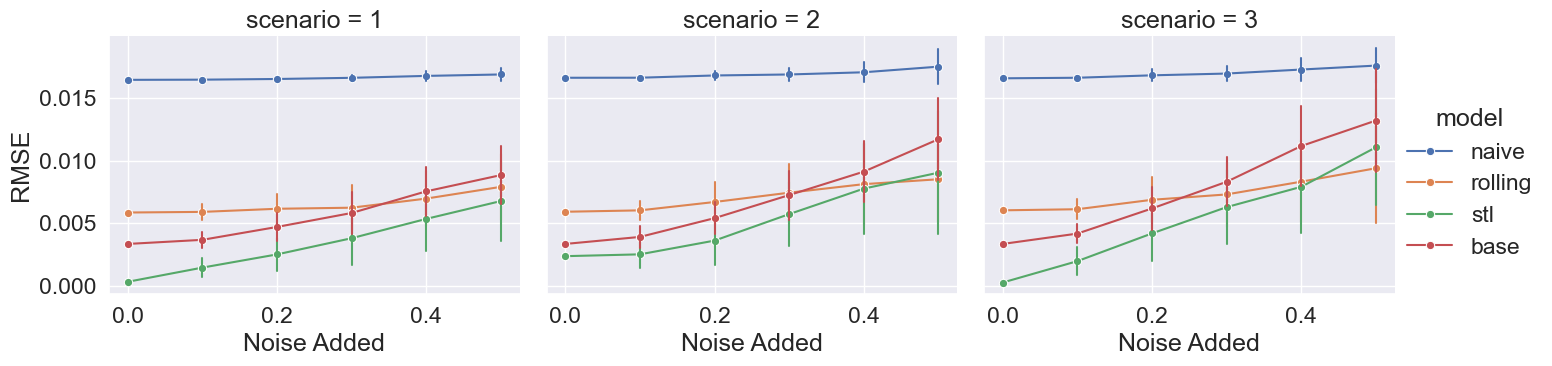

In [521]:
import seaborn as sns
noise_sub=noise_moving_rmse.loc[noise_moving_rmse['data']<=0.5]
# plot increasing removed
sns.set(font_scale=1.5)
g = sns.FacetGrid(noise_sub, col="scenario", hue='model',sharey=True, sharex=False,
                 height=4, aspect=1.2)
g.map(sns.lineplot, "data", "rmse", marker='o',err_style='bars',ci='sd')
g.add_legend()
g.set_axis_labels("Noise Added")
axes = g.axes.flatten()
axes[0].set_ylabel('RMSE')
# axes[0].set_xlabel('Proportion Data removedd')
plt.show()

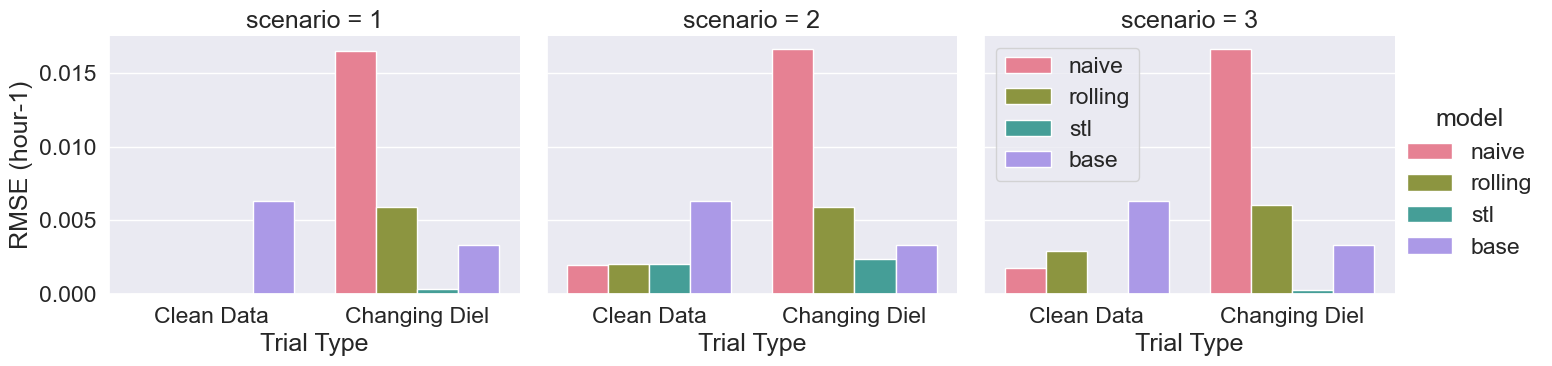

In [188]:
clean_results=pd.concat(result_dfs)
clean_results['trial']='Clean Data'
moving_results['trial']='Changing Diel'
# concatenate with moving results
scenario_trials=pd.concat([clean_results,moving_results])

sns.set(font_scale=1.5)
g = sns.catplot(data=scenario_trials, x='trial', y='rmse', hue='model', col='scenario', kind='bar',palette='husl',
               errorbar='sd',height=4, aspect=1.2)
plt.legend()
g.set_axis_labels("Trial Type",'RMSE (hour-1)')
plt.show()

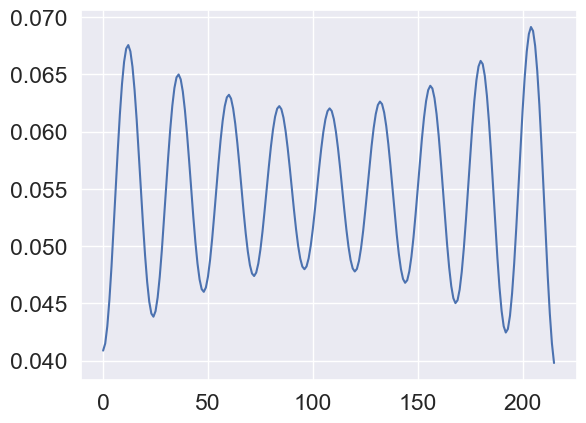

In [23]:
# generate simulation data with known periodicity of 24H, 10 full days
cycles = 10 # how many sine cycles
resolution = cycles*24 # how many datapoints to generate
# calculate length
length = np.pi * 2 * cycles
# set x with custom amplitude
x=np.arange(0, length, length / resolution)
# adjust amplitude and start/end
my_wave = np.sin(x)#*0.15 + 0.55
#am_wave=my_wave*(((x - len(x)/8) ** 2)+50)
am_wave=my_wave*(((x - length/2) ** 2)+700)/100000 + 0.055
start=np.where(my_wave == np.min(my_wave))[0][0]
end=np.where(my_wave == np.min(my_wave))[0][-1]-1
# crop wave
new_wave=am_wave[start:end+1]

plt.plot(new_wave)

In [42]:
noise_df1, growth_df=run_full_model(trial1_df, 'moving_data1',model='naive', noise=0.5)
noise_df2, growth_df=run_full_model(trial1_df, 'moving_data2',model='naive', noise=0.5)
noise_df3, growth_df=run_full_model(trial1_df, 'moving_data3',model='naive', noise=0.5)

remove_df1, growth_df=run_full_model(trial1_df, 'moving_data1',model='naive', remove=0.6)
remove_df2, growth_df=run_full_model(trial1_df, 'moving_data2',model='naive', remove=0.6)
remove_df3, growth_df=run_full_model(trial1_df, 'moving_data3',model='naive', remove=0.6)

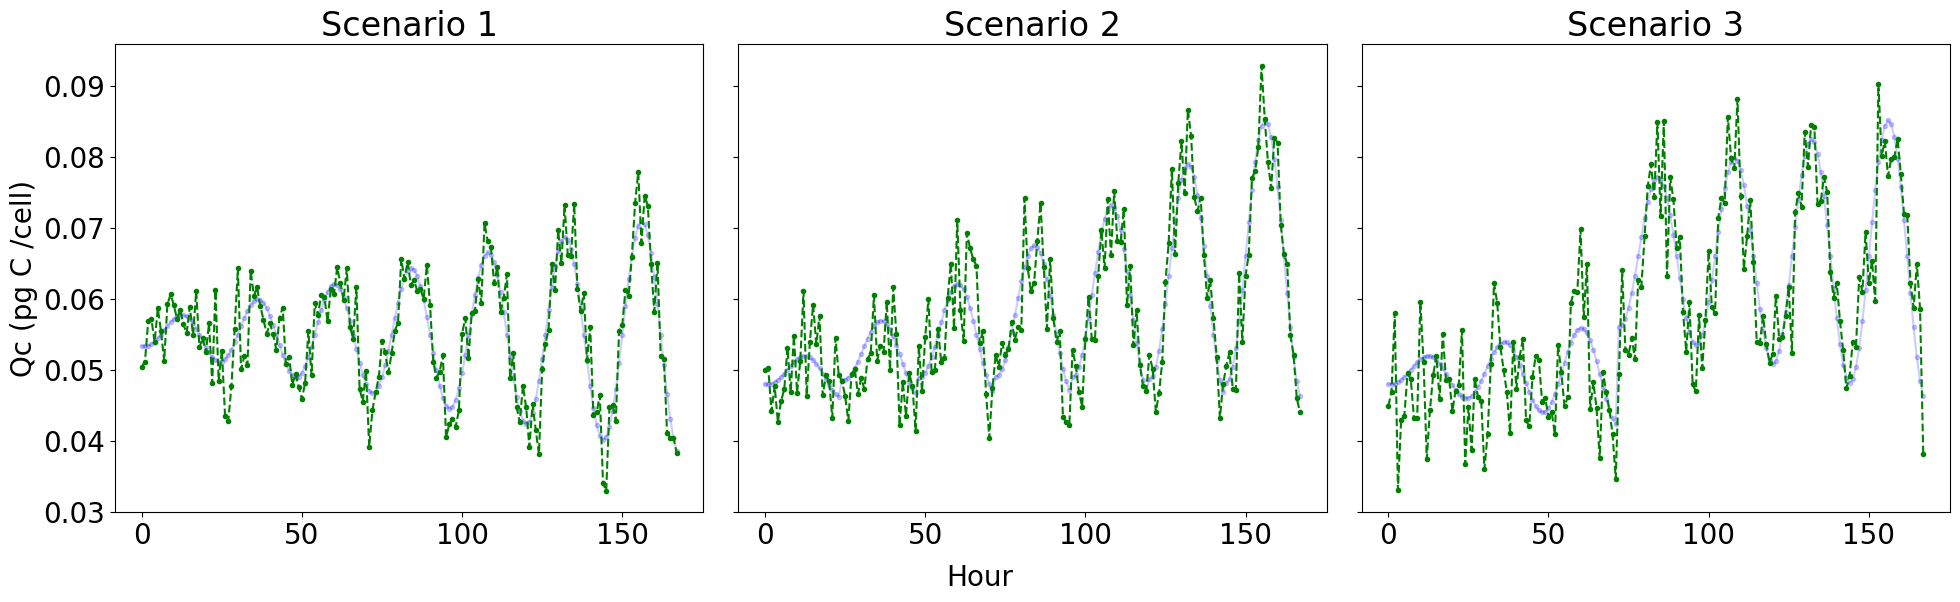

In [55]:
# show simulation data
fig,axs=plt.subplots(figsize=(20,6), ncols=3, sharey=True)
## plot scenario 1
# ln1=axs[0].plot(new_wave, marker='.', label='Constant Diel Amplitude', alpha=0.25)
# add noise and missing data 
d3=axs[0].plot(trial1_df['moving_data1'], marker='.', label='Variable Diel', c='b', alpha=0.2)
d1=axs[0].plot(noise_df1['data_with_missing'], marker='.', c='g',linestyle='--',label='Added Noise')
# d2=axs[0].plot(remove_df1['unfilled'], marker='*', c='r',linestyle='--', label='Missing Data')
lns=ln1+d3
labs = [l.get_label() for l in lns]
# axs[0].legend(lns,labs,loc='upper left')
axs[0].set_title('Scenario 1')
axs[0].set_ylabel('Qc (pg C /cell)', size=20)

## plot scenario 2
# ln2=axs[1].plot(data2, marker='.', label='Scenario 2', alpha=0.25)
d3=axs[1].plot(sim_df['moving_data2'], marker='.', c='b', label='Variable Diel', alpha=0.2)
# axs[1].plot(noise_df2['data_with_missing'], marker='.',linestyle='--',alpha=0.3)
d1=axs[1].plot(noise_df2['data_with_missing'], marker='.', c='g',linestyle='--',label='Added Noise')
# d2=axs[1].plot(remove_df2['unfilled'], marker='*', c='r',linestyle='--', label='Missing Data')
axs[1].set_title('Scenario 2')


## plot scenario 3
# ln3=axs[2].plot(breaks, marker='.', label='Constant Diel Amplitude', alpha=0.25)
d3=axs[2].plot(sim_df['moving_data3'], marker='.', c='b', label='Variable Diel', alpha=0.2)
# d2=axs[2].plot(remove_df3['unfilled'], marker='*', c='r',linestyle='--', label='Missing Data')
# axs[2].plot(noise_df3['data_with_missing'], marker='*',linestyle='--',alpha=0.25)
d1=axs[2].plot(noise_df3['data_with_missing'], marker='.', c='g',
               linestyle='--',label='Added Noise')
axs[2].set_title('Scenario 3')


fig.text(0.5, -0.01, 'Hour', ha='center', size=20)
plt.rcParams.update({'font.size':20})
# lns=ln3+d1+d2
# labs = [l.get_label() for l in lns]
# # lns=ln1+d3
# # labs = [l.get_label() for l in lns]
# axs[2].legend(lns,labs)

plt.tight_layout()
plt.show()